# Building a car price prediction model 
# Part 1: Data collection and splitting into train and validation datasets
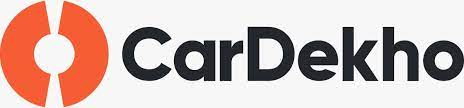
## About the project
[CarDekho](https://www.cardekho.com/) is India's leading car search venture that helps users buy cars. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons as well as videos and pictures of all car brands and models available in India. The company has tie-ups with many auto manufacturers, more than 4000 car dealers and numerous financial institutions to facilitate the purchase of vehicles.

In this project, we'll collect data about used cars from the CarDekho website, build a price prediction model and deploy it in a web app. The app may later be used by CarDekho users for evaluating the price of put up for sale vehicles or exploring collected data on their own.

The data collection and model building are described in 2 notebooks:
* Part 1: Data collection and splitting into train and validation datasets (current)
* [Part 2: Data preparation and model building](https://nbviewer.org/github/ZaikaBohdan/ds_car_price_proj/blob/main/car_price_part_2.ipynb)

**The goal of the current notebook** is to prepare train and validation datasets, which later will be used for model building and evaluating its success respectively.

## Links
* [GitHub repository of the project](https://github.com/ZaikaBohdan/ds_car_price_proj)


# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from math import ceil
from sklearn.model_selection import train_test_split
import warnings

pd.options.display.max_columns = None
%matplotlib inline

# Data Collection

Since we don't have access to the database of the CarDekho website, there are two main ways to collect data: find existing datasets or scrape data from the CarDekho website. Kaggle contains two useful for our case datasets: [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) (\~8000 rows) and [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) (\~20000 rows). We will use this data for model building, because:
* both datasets contain similar columns, which will make it easy to union them;
* in sum it is about 28000 rows, which is enough for model building;
* using existing datasets takes less time than scraping new from the website;
* according to Kaggle, ~30% of used cars from [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) were first bought in 2016-2020 and ~16% from [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) in 2018-2021. Therefore, the data is fresh enough.

## Importing the datasets

We'll start by taking a look at the first rows and shapes of datasets.

### Vehicle dataset

In [ ]:
# read in the data
raw_data_1 = pd.read_csv('https://raw.githubusercontent.com/ZaikaBohdan/ds_car_price_proj/main/data/Car%20details%20v3.csv')

raw_data_1.head()

In [ ]:
# check the shape of dataset
raw_data_1.shape

Description of fields in Vehicle dataset:
* *name* - name of the car
* *year* - year in which car was first bought
* *selling_price* - selling price of the car
* *km_driven* - number of kilometers the car is driven
* *fuel* - fuel type of the car
* *seller_type* - tells if car is sold by individual or dealer
* *transmission* - gear transmission of the car (Automatic/Manual)
* *owner* - number of previous owners
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max power of engine
* *torque* - torque of the car
* *seats* - number of seats in the car

### Used Car Prices in India dataset

In [ ]:
# read in the data
raw_data_2 = pd.read_csv('https://raw.githubusercontent.com/ZaikaBohdan/ds_car_price_proj/main/data/Cardekho_Extract.csv')

raw_data_2.head()

In [ ]:
# check the shape of dataset
raw_data_2.shape

Description of fields in Vehicle dataset:
* *Source.Name* - invalid field
* *web-scraper-order* - row id
* *web-scraper-start-url* - url of data source for current row
* *full_name* - name of the car
* *selling_price* - current selling price of used car
* *new-price* - current cost price of brand-new car
* *year* - year in which car was first bought
* *seller_type* - type of seller
* *km_driven* - kilometers driven by the car
* *owner_type* - number of previous owners
* *fuel_type* - fuel type of the car
* *transmission_type* - gear transmission of the car (Automatic/Manual)
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max horsepower of engine
* *seats* - number of seats in the car

## Dictionary of units in data
* **Lakh** - a unit in the Indian numbering system equal to one hundred thousand (100,000). In the Indian 2,2,3 convention of digit grouping, it is written as 1,00,000. For example, in India 150,000 rupees becomes 1.5 lakh rupees, written as ₹1,50,000 or INR 1,50,000.
* **Crore (Cr)** - a unit in the Indian numbering system equal to ten million (10,000,000) or 100 lakh in the Indian numbering system. It is written as 1,00,00,000 with the local 2,2,3 style of digit group separators.
* **kmpl** - Kilometers Per Liter is a term used to express the fuel efficiency of a vehicle. Fuel efficiency is defined as the ratio of distance traveled per unit of fuel consumed.
* **СС** - The term “cc” stands for Cubic Centimeters or simply cm³, which is a metric unit to measure the Engine's Capacity or its volume.
* **bhp** - Traditionally, ‘brake horsepower’ (bhp) has been used as the definitive measurement of engine power. It’s distinct from horsepower because it takes into account power loss due to friction – it’s measured by running an engine up to full revs, then letting it naturally slow down to a dead stop.
* **nm at rpm** - Torque is rotational force, and since an engine relies on a rotating crank to do its work, torque is the force the engine can generate. Modern engines generate different levels of torque at different engine speeds (RPMs, or revolutions per minute that the engine is turning through). It’s expressed in Newton-Metres (Nm), and this is what you feel when you’re pushed back into your seat on acceleration. A car brochure will indicate the maximum torque the engine can generate, and the specific RPM at which it is generated. For instance, the Maruti Dzire generates 113Nm at 4200RPM (petrol) and 190Nm at 2000RPM (diesel). This means the petrol engine produces less torque at a much higher engine speed than the diesel motor, which produces more at a quite low engine speed. The bottom line: Look for a good torque (over 110Nm) with a low RPM (4,000 or so). 1 kgm = 9.80665 Nm

# Create train and validation datasets
We will create train and validation datasets by following the next steps:
1. Find corresponding and non-corresponding columns of both datasets.
2. For both datasets separately:
    * Transform  non-null values of corresponding columns to unified format;
    * Decide if to leave or drop non-corresponding columns.
3. Combine datasets.
4. Manage duplicate rows, outliers and null values with methods that don't cause data leakage for future train/validation split.
5. Split data into train and validation datasets.

## Find corresponding and non-corresponding columns of both datasets
First, let's compare lists of datasets columns.

In [ ]:
# for printing list in bullet list style
def bullet_list(lst, header='', sort=True, counter=True):
    if header!='' or counter:
        print(f'{header} ({len(lst)}):')
    if sort:
        lst = sorted(lst)
    for el in lst:
        print('   >', el)

# for finding intersections and differences between lists of columns
def compare_cols(data_1, data_2, return_flg=False):
    set_1, set_2 = set(data_1.columns), set(data_2.columns)
    inter, diff1, diff2 = set_1.intersection(set_2), set_1.difference(set_2), set_2.difference(set_1)
    bullet_list(inter, 'Corresponding columns')
    bullet_list(diff1, 'Columns from 1st dataset, which are not present in 2nd')
    bullet_list(diff2, 'Columns from 2nd dataset, which are not present in 1st')
    if return_flg:
        return inter, diff1, diff2

In [ ]:
compare_cols(raw_data_1, raw_data_2)

Fields *fuel, owner, name, transmission* from the 1st dataset have corresponding columns with different names in the 2nd dataset (*transmission_type, fuel_type, full_name, owner_type*). We'll change the names of these fields in the 2nd dataset, so they match with the 1st one, and compare lists of columns again.

In [ ]:
cols_dict = {
    'fuel_type' : 'fuel',
    'full_name' : 'name',
    'owner_type' : 'owner',
    'transmission_type' : 'transmission'
}
raw_data_2.rename(columns=cols_dict, inplace=True)
inter_cols, diff1_cols, diff2_cols = compare_cols(raw_data_1, raw_data_2, return_flg=True)

This comparison will help us prioritize columns in the data cleaning process. Values of corresponding columns will be cleaned and transformed into a unified format since they are present in both datasets. The decision to clean or drop non-corresponding columns will depend on:
* how hard it is to fill null values in both datasets for this column;
* how significant this column is for the future model.

## Data cleaning of Vehicle dataset

Let's explore data types of fields in the 1st dataset.

In [ ]:
raw_data_1.info()

Columns *mileage, engine, max_power, torque* and *seats* have the wrong data type. In the code cells below, we will convert *mileage, engine, max_power, torque* columns to numeric data types and *seats* column to object since it is a categorical field.

### Converting *seats* column to object data type

In [ ]:
raw_data_1 = raw_data_1.astype({'seats':str})
# remove '.0' left from float data type 
raw_data_1['seats'] = raw_data_1['seats'].str.replace('.0','', regex=False).replace({'nan':np.nan})
raw_data_1.dtypes['seats']

### Converting *mileage, engine* and *max_power* to numeric data type

Columns *mileage, engine* and *max_power* have simpler and identical formats of values (*{value of the field} {unit of the field}*), so we will convert to numeric them first.

In [ ]:
def split_val_unit(df, cols):
    data = df.copy()
    for name in cols:
        try:
            data[[name+'_val', name+'_unit']] = data[name].str.split(expand=True)
                
        except Exception as e:
            print(f'Error ({name} column):')
            print(e)
            
    return data

In [ ]:
# the first run of code raised an error during an attempt to convert values to numeric because of one incorrect value in a row;
# line of code below added for fixing this value
raw_data_1.loc[raw_data_1['max_power'] == ' bhp', 'max_power'] = np.nan

conv_cols = ['mileage', 'engine', 'max_power']
raw_data_1 = split_val_unit(raw_data_1, conv_cols)
raw_data_1 = raw_data_1.astype({name+'_val':float for name in conv_cols})

all_conv_cols = np.array([[name, name+'_val', name+'_unit'] for name in conv_cols]).flatten()
raw_data_1[all_conv_cols].head()

Let's check if all values in *mileage, engine, max_power* have the same unit and convert them to a single unit if there are more than one.

In [ ]:
def list_value_counts(df, origin_cols):
    for name in origin_cols:
        print(f"<======= {name} =======>")
        print(df[name].value_counts())
        print()

In [ ]:
list_value_counts(raw_data_1, [col+'_unit' for col in conv_cols])

*mileage* has values with two different units: 'kmpl' and 'km/kg'. Usually, 'kmpl' is used for describing cars with petrol or diesel fuel and 'km/kg' - gas fuel. Before transforming values of *mileage_val* to a single unit, we should take into account the fact that 1 liter of petrol and 1 liter of diesel are not the same thing, since each of them has different properties. So even if we transform all values to a single unit, it isn't correct to use *mileage_val* as a feature for the future model. Since we don't see alternatives, we will drop this column.

In [ ]:
raw_data_1.drop(columns=['mileage', 'mileage_val', 'mileage_unit'], inplace=True)
conv_cols.remove('mileage')

Now we are ready to:
* delete *engine, max_power* and *...\_unit* columns, because we won't need them anymore;
* rename *..._val* columns to *engine_cc, max_power_bhp* and convert them to numeric type of value.

In [ ]:
def clear_val_unit_cols(df, cols):
    data = df.copy()
    for name in cols:
        data = data.astype({name+'_val':float})
        # take first value from ..._unit column to add unit as postfix for names of ..._val columns
        data = data.rename(columns={name+'_val' : name+'_'+str.lower(data[name+'_unit'][0])})
        data = data.drop(columns = [name, name+'_unit'])
    
    return data

In [ ]:
raw_data_1 = clear_val_unit_cols(raw_data_1, conv_cols)

raw_data_1.info()

As the next step, we'll convert the *torque* column to a numeric type, so we can analyze its significance for our model.

### Converting *torque* to numeric data type

Let's start by taking a look at *torque* values again.

In [ ]:
raw_data_1['torque'].dropna().head(20)

*torque* doesn’t have a uniform format and usually contains two values:
* the first one is maximum torque, which a car can generate;
* the second value is engine speeds, at which a car generates specified maximum torque in the first value.

First, we will write code for next formats which have been noticed in first 20 values:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm

With the help of *try* and *except* blocks, we'll find new formats by trial and error method and include them in the logic of our parsing code until all values in *torque* will be successfully parsed.

**Note:**
Full list of different formats in *torque* after trial and error process:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm
* 6.1kgm@ 3000rpm
* 250Nm@ 1500~4500rpm
* 96 Nm at 3000 rpm
* 400Nm
* 135 Nm at 2500  rpm (double space between '2500' and 'rpm' + space in the end)
* 96  Nm at 3000  rpm (same as previous + double space between '96' and 'Nm')
* 51Nm@ 4000+/-500rpm
* 48@ 3,000+/-500(NM@ rpm)
* 510@ 1600-2400
* 135.4Nm@ 2500
* 210 / 1900

In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def split_torque(row):
    """
    Splits 'torque' value in a row and creates 4 new fields: 
    > 'torque_val' - value of car max torque;
    > 'torque_unit' - unit of value in 'torque_val';
    > 'torque_eng_sp_val' - value of engine speed at which car max torque is reached;
    > 'torque_eng_sp_unit' - unit of value in 'torque_eng_sp_val';
    """
    torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit = np.nan, np.nan, np.nan, np.nan
    
    # skip null values
    if row['torque'] is np.nan:
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
        
    # clear torque value from ',' and tailing ')', split and save in temporary list
    temp = re.split(
        '\(11.2\)@ |\(38.7kgm\)@ |\+\/-500r|\+\/-500\(N|  N| N| r|N|@ r|@ |  r|r|\(k|\(| at |n|-|~| k|k| \/ | \/|\s',
        str(row['torque']).replace(',','').strip(' \)')
    )
    
    # first element of split should be number, helps find cases that should be added in the logic of code
    if is_number(temp[0]):
        torque_val = float(temp[0])
    else:
        print('>>> Error_1:', temp, '\n\n', row, '\n\n\n')
     
    try:
        if is_number(temp[1]):
            torque_eng_sp_val = float(temp[1])
            if len(temp) == 2:
                torque_unit = 'Nm'
                torque_eng_sp_unit = 'rpm'
            elif len(temp) > 2:
                if is_number(temp[2]):
                    torque_eng_sp_val = (float(temp[1])+float(temp[2]))/2
                    torque_unit = 'Nm'
                    torque_eng_sp_unit = 'rpm'
                else:
                    torque_unit = temp[2]
                    torque_eng_sp_unit = temp[3]
        elif len(temp) == 2:
            torque_unit = temp[1]
        elif len(temp) == 3:
            torque_unit = temp[1]
            torque_eng_sp_val = float(temp[2])
            torque_eng_sp_unit = 'rpm'
        elif len(temp) == 4:
            if is_number(temp[3]):
                torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
                torque_eng_sp_unit = 'rpm'
                torque_unit = temp[1]
            else:
                torque_unit = temp[1]
                torque_eng_sp_val = float(temp[2])
                torque_eng_sp_unit = temp[3]
        elif len(temp) == 5:
            torque_unit = temp[1]
            torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
            torque_eng_sp_unit = temp[4]
        # else statement helps find cases that should be added in the logic of code
        else:
            print('>>> Error_2:', temp, '\n\n', row, '\n\n\n')
        
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
    # in case some error is raised during assigning new values, helps find cases that should be added in the logic of code
    except:
        print('>>> Error_3:', temp, '\n\n', row, '\n\n\n')
        
def parse_torque(df):
    data = df.copy()
    
    # split torque
    torque_new_cols = ['torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']
    data[torque_new_cols] = data.apply(split_torque, axis=1, result_type="expand")
    
    # fix units after spliting
    data['torque_unit'] = data['torque_unit'].replace({
        'm': 'nm',
        'gm': 'kgm',
        'Nm': 'nm',
        'KGM': 'kgm',
        'M': 'nm'
    })
    data['torque_eng_sp_unit'] = data['torque_eng_sp_unit'].replace({
        'pm': 'rpm',
        'RPM': 'rpm'
    })
    
    return data

In [ ]:
raw_data_1 = parse_torque(raw_data_1)
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

Let's check if all values in *torque_unit* and  *torque_eng_sp_unit* have the same unit and convert them to a single unit if there are more than one.

In [ ]:
torque_cols = ['torque', 'torque_eng_sp']
list_value_counts(raw_data_1, [col+'_unit' for col in torque_cols])

We will convert 'kgm' values in *torque_val* to 'nm' (1 kgm = 9.80665 Nm).

In [ ]:
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val'] = 9.80665 * raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val']
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_unit'] = 'nm'
list_value_counts(raw_data_1, ['torque_unit'])
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

Let's delete *torque_unit, torque_eng_sp_unit* columns and convert *torque_val, torque_eng_sp_val* to numeric data type.

In [ ]:
# dummy column for calling clear_val_unit_cols() function
raw_data_1['torque_eng_sp'] = np.nan

raw_data_1 = clear_val_unit_cols(raw_data_1, torque_cols)
raw_data_1.info()

Now all columns have the right data type, and we are ready to explore the significance of the *torque_nm* and *torque_eng_sp_rpm* columns.

### Exploring significance of *torque_nm* and *torque_eng_sp_rpm* columns for future model

As was mentioned at the start of the Data Cleaning section, we will decide if to clean or drop *torque_nm* and *torque_eng_sp_rpm* columns by analyzing:
1. how hard it is to fill null values in both datasets for this column;
2. how significant this column is for the future model.

There are ways to fill null values for these columns:
* in the first dataset there are only 256 null values (~3% of data) in *torque_nm* and *torque_eng_sp_rpm*, so we can easily impute them;
* the second dataset doesn't have such columns. We can collect *torque* values by web scraping with the help of the *web-scraper-start-url* column, but it is a time-consuming process. That's the reason why we will first check on existing data if these columns are significant for the future model before taking such an approach.

To test the significance of *torque_nm* and *torque_eng_sp_rpm* columns, we will plot their non-null values with target column 'selling_price' values and calculate Pearson’s and Spearman’s rank correlation coefficients.

In [ ]:
def plot_col_signif(df, feat_cols, targ_col, n_rows=1, n_cols=1):
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                feat_col = feat_cols[i*n_cols+j]
            except:
                plt.show()
                return
            
            pears_corr = df.corr()[feat_col][targ_col]
            spear_corr = df.corr(method='spearman')[feat_col][targ_col]

            axes[i,j].scatter(df[feat_col], df[targ_col])
            axes[i,j].set_xlabel('feature')
            axes[i,j].set_ylabel('target')
            axes[i,j].set_title(f'Feature: {feat_col}\nPearson\'s r = {pears_corr:.2f}\n Spearman\'s ρ = {spear_corr:.2f}')
            
    plt.show()

In [ ]:
plot_col_signif(raw_data_1, ['torque_nm', 'torque_eng_sp_rpm', 'cost_of_km'], 'selling_price', 1, 2)

*torque_...* columns seem to have outliers. For now, we will ignore them.

In [ ]:
plot_col_signif(raw_data_1[raw_data_1['torque_nm'] < 750], ['torque_nm', 'torque_eng_sp_rpm'], 'selling_price', 1, 2)

*torque_eng_sp_rpm* column has low correlation coefficients, so we can confidently drop it. However, *torque_nm* moderately correlated with the target column, so let's explore correlation coefficients of *selling_price* and *torque_nm* with other columns.

In [ ]:
raw_data_1.drop(columns='torque_eng_sp_rpm', inplace=True)

ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr()[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Pearson\'s r')
plt.show()

In [ ]:
ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr(method='spearman')[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Spearman\'s ρ')
plt.show()

Correlation matrixes show that *torque_nm* has one of the highest correlation coefficients with the target column in comparison with other features. At the same time, it is highly correlated with *max_power_bhp*, which has even higher correlation coefficients with the target column. 

Since filling the null values for the *torque_nm* column in the second dataset is a time-consuming process and there is a field in the dataset that highly correlates with it, we will drop this column from the first dataset.

In [ ]:
raw_data_1.drop(columns='torque_nm', inplace=True)

## Data cleaning of Used Car Prices in India dataset
First, we will delete the *mileage* column, since we did so in the 1st dataset.

In [ ]:
raw_data_2.drop(columns=['mileage'], inplace=True)

Let's explore data types of fields in the 2nd dataset.

In [ ]:
raw_data_2.info()

### Dropping *new-price* columns
Before moving forward, the output of the code cell above shows that the *new-price* column contains more than 50% of null values in the second dataset. We will print links (*web-scraper-start-url* column) of the first five cars where the *new-price* column is not null to check if the value of this field is present on the website.

In [ ]:
for i in range(5):
    print(raw_data_2.loc[~raw_data_2['new-price'].isnull()].reset_index()['web-scraper-start-url'][i])

At the time of writing, only 2 of 5 web pages still contain information about the price of a new car (see screenshots below).

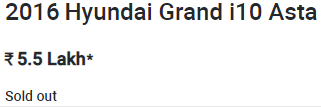

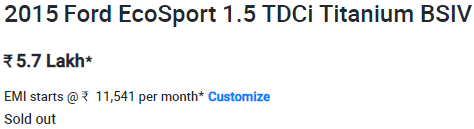

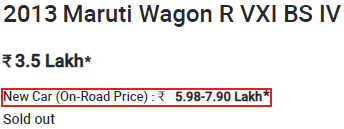

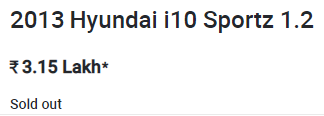

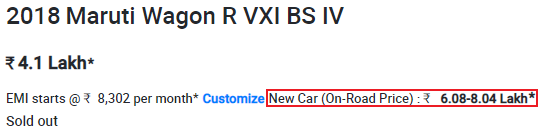

The reason for the disappearance of this information may be that it is based on current offers of new cars on the CarDekho website. As a result, it will be hard and time-consuming to fill null values for the *new-price* column in both datasets, so we will drop this field.

In [ ]:
raw_data_2.drop(columns='new-price', inplace=True)

### Converting corresponding columns to the right data types

Now let's return to exploring data types of fields in the 2nd dataset.

In [ ]:
raw_data_2.head()

In [ ]:
raw_data_2.info()

Columns *selling_price, km_driven, engine, max_power* and *seats* have wrong data type or dirty values. In the code cells below, we will fix it types by following the next steps:
1. Remove heading words from *engine, max_power, seats* columns;
2. Remove commas from the *km_driven* column;
3. Split *selling_price, km_driven, engine, max_power* into value (*..._val*) and unit (*..._unit*) columns;
4. Convert *..._val* columns to numeric data type;
5. Transform value and unit columns into unified units;
6. Drop original and *..._unit* columns.

In [ ]:
# step 1
for col, word in zip(['engine', 'max_power', 'seats'], ['Engine', 'Max Power', 'Seats']):
    raw_data_2[col] = raw_data_2[col].str.replace(word,'').str.strip('\n')

# step 2
raw_data_2['km_driven'] = raw_data_2['km_driven'].str.replace(',','')

# step 3
conv_cols_2 = ['selling_price', 'km_driven', 'engine', 'max_power']
raw_data_2 = split_val_unit(raw_data_2, conv_cols_2)

raw_data_2.head()

*split_val_unit()* function returned error for *engine* column. Let's explore why by taking a look at the split of this column.

In [ ]:
tmp = raw_data_2['engine'].str.split(expand=True)
tmp.head()

*engine* column contains messy data. We will print unique values of the 2nd, 3rd and 4th elements of the split, which may help us in finding rows with mistakes later.

In [ ]:
for i in range(3):
    print(f'>>> Split element №{i+2}')
    print(raw_data_2['engine'].str.split(expand=True).iloc[:,i+1].value_counts())
    print()

Rows with messy data contain 'SizeN/A' or 'Size17' in the 2nd element of the *engine* split. Let's take a look at them.

In [ ]:
raw_data_2[tmp.iloc[:,1].isin(['SizeN/A', 'Size17'])].head()

The output of the code cell above shows that:
* *selling_price* have values with xx,xxx* format, which should be taken into account when we split this column;
* in this slice of data:
    * *engine* contains wrong data;
    * data from *max_power* should be in *seats* column;

Let's fix these problems in the code cell below and repeat the splitting of values.

In [ ]:
# fix found issues with data
## xx,xxx* format in selling_price
with warnings.catch_warnings(): # suppress warning about future updates for regex in pandas
    warnings.simplefilter(action='ignore', category=FutureWarning)
    raw_data_2['selling_price'] = raw_data_2['selling_price'].str.replace(',','').str.replace('\d\*','0 *', regex=True)
## data from max_power should be in seats column
raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), 'seats'] = raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), 'max_power'] 
## removing incorret data from 'engine' and 'max_power' columns
raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), ['engine', 'max_power']] = np.nan

# repeat step 1 and 3 after fix in 'engine', 'max_power', 'seats' columns
for col, word in zip(['engine', 'max_power', 'seats'], ['Engine', 'Max Power', 'Seats']):
    raw_data_2[col] = raw_data_2[col].str.replace(word,'').str.strip('\n')

raw_data_2 = split_val_unit(raw_data_2, conv_cols_2)

# step 4
## while/try/except helps find all exceptions and deal with them
def df_float(df, cols):
    data = df.copy()
    flg = True
    while flg:
        try:
            data = data.astype({col:float for col in cols})
            flg = False
        except Exception as e:
            error_val = str(e).replace("could not convert string to float: '", "").strip("'")
            data[cols] = data[cols].replace({error_val:np.nan})
            print('Fixed: '+str(e))
            
    return data


num_cols_2 = [name+'_val' for name in conv_cols_2]
raw_data_2 = df_float(raw_data_2, num_cols_2)
print()

# step 5
list_value_counts(raw_data_2, [col+'_unit' for col in conv_cols_2])

The *selling_price* column has more than one unit, so we will convert *selling_price* to 'inr' unit (code for Indian Rupee).

In [ ]:
# continuation of step 5
raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Cr*', 'selling_price_val'] = 10**7 * raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Cr*', 'selling_price_val']
raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Lakh*', 'selling_price_val'] = 10**5 * raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Lakh*', 'selling_price_val']
raw_data_2['selling_price_unit'] = 'inr'

list_value_counts(raw_data_2, [col+'_unit' for col in conv_cols_2])

In [ ]:
# step 6
raw_data_2 = clear_val_unit_cols(raw_data_2, conv_cols_2)

raw_data_2.info()

In [ ]:
raw_data_2.head()

### Managing non-corresponding columns
*Source.Name* and *web-scraper-order* columns will be dropped since they carry no information about cars. *web-scraper-start-url* column will be left for now, since it may help us in dealing with outliers and null-values, but we will rename it to 'url' for convenience.

In [ ]:
raw_data_2.drop(columns=['Source.Name', 'web-scraper-order'], inplace=True)
raw_data_2.rename(columns={'web-scraper-start-url':'url'}, inplace=True)
raw_data_2.info()

## Combining the datasets

Let's check if all columns are corresponding in both datasets before combining them.

In [ ]:
compare_cols(raw_data_1, raw_data_2)

We will rename *km_driven_kms, selling_price* columns to *km_driven, selling_price_inr* and add *url* column with null values in 1st dataset.

In [ ]:
raw_data_1.rename(columns={'selling_price':'selling_price_inr'}, inplace=True)
raw_data_2.rename(columns={'km_driven_kms':'km_driven'}, inplace=True)
raw_data_1['url'] = np.nan
compare_cols(raw_data_1, raw_data_2)
print()
raw_data_1.info()

Now we are ready to concatenate the datasets.

In [ ]:
raw_data = pd.concat([raw_data_1, raw_data_2], ignore_index = True)
raw_data.info()

## Managing duplicate rows
Let's check if the data contains any duplicate rows and drop them.

In [ ]:
clean_df = raw_data.copy()
print("Number of rows before cleaning duplicates:", clean_df.shape[0])
cols_no_url = list(clean_df.columns)
cols_no_url.remove('url')
clean_df.drop_duplicates(subset=cols_no_url, inplace=True, ignore_index=True)
print("Number of rows after cleaning duplicates:", clean_df.shape[0])

## Managing outliers caused by an error

### Numeric fields: Box plot diagrams
Let's take a look at possible numeric outliers by plotting box plot diagrams for numeric fields.

In [ ]:
def plot_whiskers(df, numeric_cols = None, n_rows=None, n_cols=None):
    if numeric_cols is None:
        numeric_cols = list(df.select_dtypes(include='number').columns)
        
    if n_rows is None or n_cols is None:
        n_cols = 2
        n_rows = ceil(len(numeric_cols) / 2)
    
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)
    
    plt.suptitle('Boxplots', fontsize='xx-large', fontweight='bold')
    for i in range(n_rows):
        for j in range(n_cols):            
            try:
                col = numeric_cols[i*n_cols+j]
            except:
                plt.show()
                return

            sns.boxplot(data=df, x=col, orient='h', ax=axes[i,j])
            #clear xlabel
            axes[i,j].set_xlabel('')
            axes[i,j].set_title(f'{col}', fontsize='xx-large')

    plt.show()

In [ ]:
plot_whiskers(clean_df)

The suspicious values which we will explore further are:
* *selling_price_inr > 20,000,000*
* *km_driven > 1,000,000*
* *engine_cc < 400*
* *max_power_bhp = 0*

#### *selling_price_inr > 20,000,000*

In [ ]:
clean_df[clean_df['selling_price_inr'] > 2 * 10**7]

These cars have such high prices because they are from the premium class, so these outliers are not caused by errors in data.

#### *km_driven > 1,000,000*

In [ ]:
clean_df[clean_df['km_driven'] > 10**6]

These values also seem to be right.

#### *engine_cc < 400*

In [ ]:
clean_df[clean_df['engine_cc'] < 400]

All cars with *engine_cc < 400* are electric. This can be explained by the fact that electric cars have a motor instead of an engine, so they should contain null values in *engine_cc*. Before moving forward, let's check if all non-null values in *engine_cc* are lower than 400 for electric cars.

In [ ]:
clean_df[(clean_df['fuel']=='Electric') & (clean_df['engine_cc'] >= 400)]

Values of *fuel* in the above data slice are probably incorrect since hybrid cars use petrol as the main fuel. We will fix it in the next code cell and assign a null value to *engine_cc*, where *engine_cc < 400*.

In [ ]:
clean_df.loc[clean_df['name']=='Toyota Camry Hybrid', 'fuel'] = 'Petrol'
clean_df.loc[clean_df['engine_cc'] < 400, 'engine_cc'] = np.nan

#### *max_power_bhp = 0*

In [ ]:
clean_df[clean_df['max_power_bhp'] == 0]

Obviously, '0' values in *max_power_bhp* should be replaced with null.

In [ ]:
clean_df.loc[clean_df['max_power_bhp'] == 0, 'max_power_bhp'] = np.nan

### Numeric fields: Descriptive statistics
As a last check of numeric fields, we will take a look at their descriptive statistics.

In [ ]:
clean_df.describe()

Let's examine rows with 5 smallest *km_driven* values.

In [ ]:
clean_df.nsmallest(5, 'km_driven')

It is very unlikely that 4 or more owners have driven 1 km in total from 2011, so we will assign a null value to *km_driven* of row with index 6737.

In [ ]:
clean_df['km_driven'] = clean_df['km_driven'].replace({1.0:np.nan})
clean_df.describe()

As can be seen, there are no more visible outliers left in numeric fields.
### Categorical fields
Let's take a look at the unique values of categorical fields to see if there are any errors.

In [ ]:
categ_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']
list_value_counts(clean_df, categ_cols)

The suspicious values which we will explore further are:
* *seller_type = 'Trustmark Dealer'*
* *owner = 'Test Drive Car'*
* *seats  = 'N/A'*

Other categorical columns have understandable and right values.
### *seller_type = 'Trustmark Dealer'*
We will replace 'Trustmark Dealer' values in *seller_type* with 'Dealer' since they are a subcategory of 'Dealer' and ~0.8% of data.

In [ ]:
clean_df['seller_type'] = clean_df['seller_type'].replace({'Trustmark Dealer':'Dealer'})

### *owner = 'Test Drive Car'*
It is not clear what *owner* = 'Test Drive Car' means, so we will take a look at rows with such value.

In [ ]:
clean_df[clean_df['owner'] == 'Test Drive Car']

Since they have low values in *km_driven*, they may be used for test-driving in a car dealership, and we will assign them to the 'First Owner' group.

In [ ]:
clean_df['owner'] = clean_df['owner'].replace({'Test Drive Car':'First Owner'})

### *seats  = 'N/A'*
We will replace 'N/A' values in *seats* with nulls.

In [ ]:
clean_df['seats'] = clean_df['seats'].replace({'N/A':np.nan})

In [ ]:
list_value_counts(clean_df, ['seller_type', 'owner', 'seats'])

## Managing null values
Let's take a look at the number of null values in the data (without the *url* column).

In [ ]:
def null_counter(df):
    display(
        pd.DataFrame(
            df.isnull().sum(axis=1).value_counts().sort_index(ascending=False)
        ).reset_index().rename(columns={'index':'n_nulls', 0:'n_rows'})
    )

In [ ]:
null_counter(clean_df.loc[:, clean_df.columns != 'url'])

We'll drop an empty row and explore in greater detail other rows with null values.

In [ ]:
clean_df = clean_df[clean_df.isnull().sum(axis=1)!=11].reset_index(drop=True)

In [ ]:
def n_nulls_cols_counter(df, n_nulls):
    print(
        df[df.isnull().sum(axis=1)==n_nulls].apply(lambda row: frozenset(df.columns[row.isnull()]), axis=1).value_counts()
    )

def all_null_cols_counter(df):
    uniq_n_nulls = sorted(df.isnull().sum(axis=1).unique(), reverse = True)[:-1]
    for n in uniq_n_nulls:
        print('>>> List of columns with null values, where amount of nulls =', n,'<<<')
        n_nulls_cols_counter(df, n)
        print()

In [ ]:
all_null_cols_counter(clean_df.loc[:, clean_df.columns != 'url'])

*engine_cc, max_power_bhp* and *seats* columns with null values are features of a car that are not influenced by age. That's why we will try to find values for these fields in other rows by searching the name of the car.

In [ ]:
def fillna_by_col(data, col):
    df = data.copy()
    unique_vals = df.loc[df.isnull().any(axis=1), col].unique()
    for val in unique_vals:
        df[df[col]==val] = df[df[col]==val].ffill().bfill()
    
    return df

In [ ]:
cols = list(clean_df.columns)
for col in ['url', 'km_driven']:
    cols.remove(col)
clean_df.loc[:, cols] = fillna_by_col(clean_df.loc[:, cols], 'name')
all_null_cols_counter(clean_df.loc[:, clean_df.columns != 'url'])

The amount of null values is too big to fill them manually and other methods of imputing nulls may cause data leakage, so we are stopping the data cleaning process here. We will drop the *url* column since we won't need it anymore.

In [ ]:
clean_df = clean_df.drop(columns='url')
clean_df.columns

## Split data into train and validation datasets
Let's print descriptive statistics of selling prices, which will help us later to confirm that we split data correctly. 

In [ ]:
clean_df['selling_price_inr'].describe()

We will split data into random train and validation subsets with the proportion 9:1 respectively and save them in the 'data' folder.

In [ ]:
train_df, valid_df = train_test_split(clean_df, train_size=0.9, random_state=3)
print(f'Train dataset shape: {train_df.shape}, {len(train_df)/len(clean_df)*100 : .2f}%')
print(train_df['selling_price_inr'].describe())
print()
print(f'Validation dataset shape: {valid_df.shape}, {len(valid_df)/len(clean_df)*100 : .2f}%')
print(valid_df['selling_price_inr'].describe())

In [ ]:
train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

That's the end of part 1 of the 'Building a car price prediction model for the CarDekho website' project. [In the next part](https://nbviewer.org/github/ZaikaBohdan/ds_car_price_proj/blob/main/car_price_part_2.ipynb), we will explore the train dataset and build the model based on it.